# Boltzmann Wealth Model

In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation  #activation order of agents matters but 
#there are 3 implementations - Random, Simultaneous
%matplotlib inline
import matplotlib.pyplot as plt
import random
#import seaborn as sns
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector


## Establishes Agent Class 
 1. Attributes (wealth) whe agent is initialized 
 2. move - move through multigrid
 3. give money - identify neighbors, give money 
 4. Step which is action agent  takes each time iteration 

In [12]:
# Set up initial agents  this is where you typically assign your attirbutes for each agent object
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()
            
    

# Model class retains all agents and runs each step of the model 

# Contains 
1. activation object - randomly shuffle agent order each step
2. world (i.e. multigrid) -allows more than one agent on a spot
3. data collector - collects data on agents
4. agent population
5. gini coefficient function - kept outside class for batch runner/ model class interaction 
6. step function for model



In [13]:
def compute_gini(model):
        agent_wealths = [agent.wealth for agent in model.schedule.agents]
        x = sorted(agent_wealths)
        N = model.num_agents
        B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
        return (1 + (1/N) - 2*B)

In [14]:
# Your model class which stores all your agents
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        
        # create a datacollector to caputre key metric
        self.datacollector = DataCollector(
                model_reporters={"Gini": compute_gini},  # A function to call
                agent_reporters={"Wealth": "wealth"})  # An agent attribute
        
        # Create population of agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

            # Add the agent to a random grid cell
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))  
    
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

## Run the model and plot the results

## Runs 50 Agents in a 10 X 10 grid

In [15]:
model = MoneyModel(100, 10, 10)
for i in range(100):
    model.step()

# Plot Location and Wealth

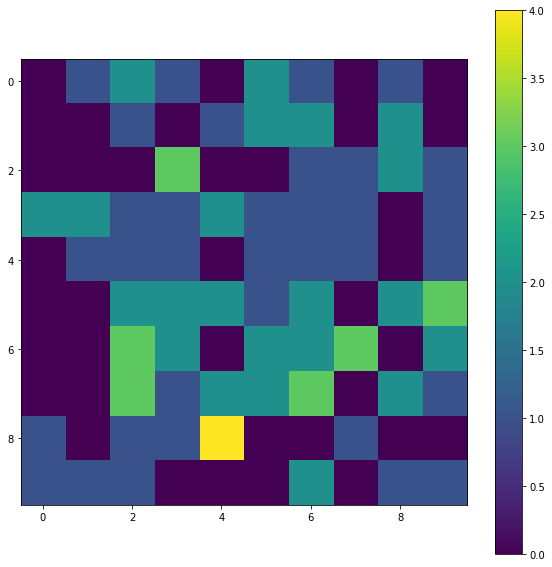

In [16]:
import numpy as np

plt.figure(figsize=(10,10))

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

# If running from a text editor or IDE, remember you'll need the following:


# Plot Gini Coefficient - g coefficient by step

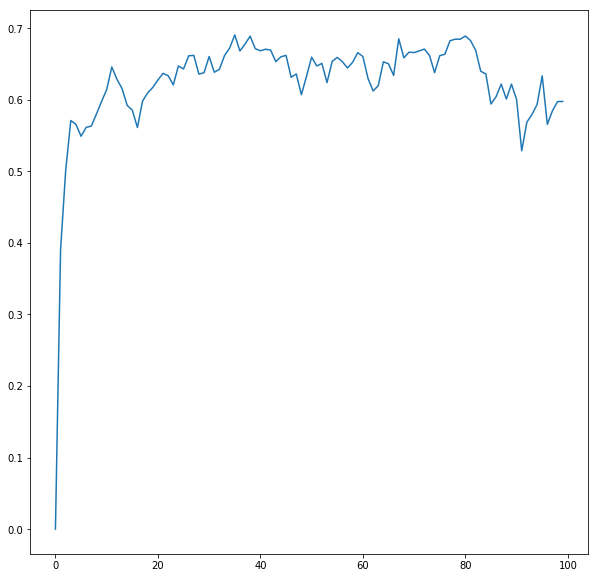

In [17]:
plt.figure(figsize=(10,10))
gini = model.datacollector.get_model_vars_dataframe()
plt.plot(gini)

# See Dataframe of Plot

In [18]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1
     5             1
     6             1
     7             1
     8             1
     9             1
     10            1
     11            1
     12            1
     13            1
     14            1
     15            1
     16            1
     17            1
     18            1
     19            1
     20            1
     21            1
     22            1
     23            1
     24            1
     25            1
     26            1
     27            1
     28            1
     29            1
...              ...
99   70            1
     71            1
     72            0
     73            3
     74            1
     75            0
     76            0
     77            0
     78            3
     79            0
     80            0
     81            2
     82            2
     83            0
     84            0
     85            0
     86            3
     87            2
     88            0
     89            3
     90            1
     91            0
     92            0
     93            2
     94            0
     95            4
     96            2
     97            3
     98            2
     99            4

[10000 rows x 1 columns]

# Plot Histogram of Step 

(array([ 45.,  29.,  17.,   3.,   3.,   2.,   1.,   0.,   0.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

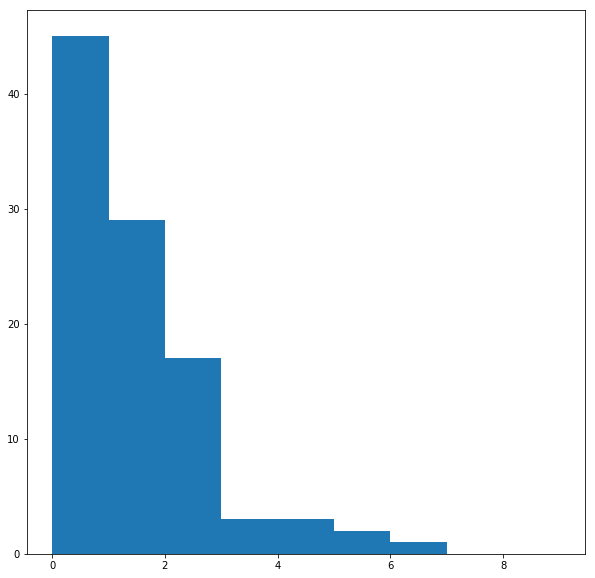

In [19]:
plt.figure(figsize=(10,10))
end_wealth = agent_wealth.xs(19, level="Step")["Wealth"] # .xs is a pandas dataframe to get a cross section of the frame 
plt.hist(end_wealth, bins=range(agent_wealth.Wealth.max()+1))

# Plot Path of One Agent

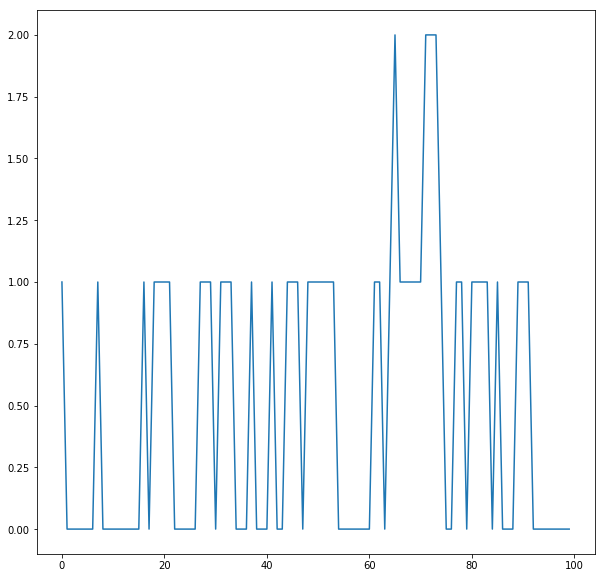

In [20]:
plt.figure(figsize=(10,10))

one_agent_wealth = agent_wealth.xs(20, level="AgentID")
plt.plot(one_agent_wealth)

## BATCH RUNNER

Adds one element - self.running = True

In [23]:
from mesa.batchrunner import BatchRunner

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True 
        # create a datacollector to caputre key metric
        self.datacollector = DataCollector(
                model_reporters={"Gini": compute_gini},  # A function to call
                agent_reporters={"Wealth": "wealth"})  # An agent attribute
        
        # Create population of agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

            # Add the agent to a random grid cell
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
   
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [24]:
fixed_params = {"width": 10,
                "height": 10}
variable_params = {"N": range(10, 500, 10)}

batch_run = BatchRunner(MoneyModel,
                        fixed_parameters=fixed_params,
                        variable_parameters=variable_params,
                        iterations=5,
                        max_steps=100,
                        model_reporters={"Gini": compute_gini})
batch_run.run_all()

245it [00:37,  6.56it/s]


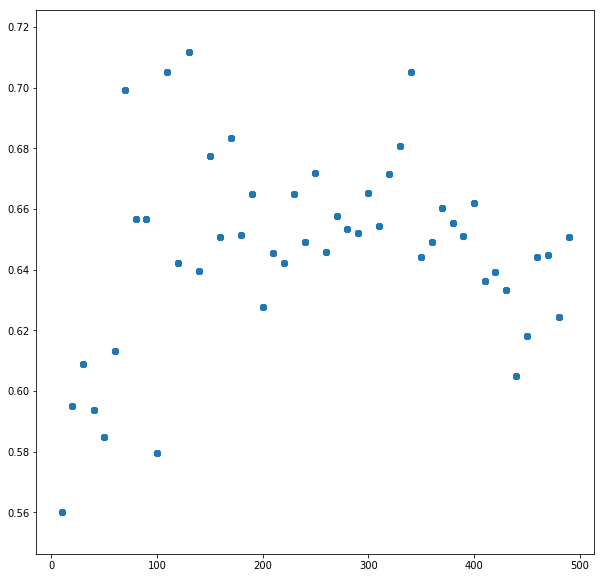

In [25]:
plt.figure(figsize=(10,10))

run_data = batch_run.get_model_vars_dataframe()
run_data.head()
plt.scatter(run_data.N, run_data.Gini)